In [29]:
!pip install yfinance pandas pandas-ta matplotlib mplfinance prophet

# Import Python Libraries and set defalut value

In [30]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import datetime, timedelta

In [31]:
# --- Ngày kết thúc: 11/10/2025 ---
end_date = datetime(2025, 10, 11)
# --- Ngày bắt đầu: lùi 10 năm ---
start_date = end_date - timedelta(days=365 * 10)

# 10 tickers ngân hàng Mỹ
us_bank_tickers = [
    "JPM",  # JPMorgan Chase
    "BAC",  # Bank of America
    "WFC",  # Wells Fargo
    "C",    # Citigroup
    "GS",   # Goldman Sachs
    "MS",   # Morgan Stanley
    "USB",  # U.S. Bancorp
    "PNC",  # PNC Financial Services
    "TFC",  # Truist Financial
    "COF"   # Capital One
]


# Price-volumn data: open, high, low, close (OHLC), Adjusted prices, Volume

In [32]:
def clean_stock_df(df, symbol):
    """
    Làm phẳng MultiIndex, thêm cột Symbol,
    loại bỏ header trùng, giữ NaN thực tế
    """
    # Nếu df có MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Reset index để Date thành cột
    df = df.reset_index()
    df = df.rename(columns={df.columns[0]: "Date"})

    # Thêm cột Symbol
    df["Symbol"] = symbol

    # Loại bỏ các dòng header trùng lặp
    df = df[~df["Date"].isin(["Date", "Ticker"])]

    # Convert Date, bỏ NaT (nan time)
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])

    # Sắp xếp cột
    cols = ["Symbol", "Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"]
    df = df[cols].reset_index(drop=True)

    return df


In [33]:
stock_data = {}  # Lưu DataFrame từng ticker
for t in us_bank_tickers:
    try:
        df = yf.download(
            t, start=start_date, end=end_date,
            progress=False, auto_adjust=False  # giữ NaN thực tế
        )
        if df.empty:
            print(f"No data found for {t}")
            continue
        stock_data[t] = df
        print(f"Downloaded {t}: {len(df)} rows")
    except Exception as e:
        print(f"Error loading {t}: {e}")

Downloaded JPM: 2513 rows
Downloaded BAC: 2513 rows
Downloaded WFC: 2513 rows
Downloaded C: 2513 rows
Downloaded GS: 2513 rows
Downloaded MS: 2513 rows
Downloaded USB: 2513 rows
Downloaded PNC: 2513 rows
Downloaded TFC: 2513 rows
Downloaded COF: 2513 rows


In [34]:
# Làm sạch và ghép tất cả vào 1 DataFrame
cleaned_list = []
for t, df in stock_data.items():
    df_clean = clean_stock_df(df, t)
    cleaned_list.append(df_clean)

df_all_clean = pd.concat(cleaned_list, ignore_index=True)


In [35]:
print(df_all_clean.head())
print("\nTicker có trong dataset:", df_all_clean["Symbol"].unique())
print("Shape:", df_all_clean.shape)

Price Symbol       Date  Adj Close      Close       High        Low  \
0        JPM 2015-10-14  45.772930  59.990002  60.970001  59.540001   
1        JPM 2015-10-15  47.222641  61.889999  61.959999  60.099998   
2        JPM 2015-10-16  47.634663  62.430000  62.650002  62.090000   
3        JPM 2015-10-19  47.474430  62.220001  62.770000  61.910000   
4        JPM 2015-10-20  47.703327  62.520000  62.820000  62.080002   

Price       Open    Volume  
0      60.759998  28989400  
1      60.470001  18147900  
2      62.430000  17456600  
3      62.000000  14510400  
4      62.360001  11545100  

Ticker có trong dataset: ['JPM' 'BAC' 'WFC' 'C' 'GS' 'MS' 'USB' 'PNC' 'TFC' 'COF']
Shape: (25130, 8)


In [36]:
df=df_all_clean

In [39]:
# Chuẩn hóa tên cột
df = df.rename(columns={
    'Adj Close': 'Adjusted Close',
    'Symbol': 'US_Bank'
})

# Giữ và sắp xếp các cột cần thiết
ordered_columns = ['Date', 'US_Bank', 'Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume']
existing_columns = [col for col in ordered_columns if col in df.columns]
data_final = df[existing_columns]

# Chuyển kiểu dữ liệu ngày tháng (Date) và sắp xếp lại
data_final['Date'] = pd.to_datetime(data_final['Date'], errors='coerce')
data_final = data_final.sort_values(['US_Bank', 'Date']).reset_index(drop=True)
data_final.columns.name = None

# Kết quả cuối cùng là DataFrame phẳng
print("\n DataFrame sau khi chuyển dạng (flat):\n")
print(data_final.head())
print("\n Kiểm tra index:", data_final.index)
print("\n Kiểu dữ liệu:")
print(data_final.dtypes)




 DataFrame sau khi chuyển dạng (flat):

        Date US_Bank       Open       High        Low      Close  \
0 2015-10-14     BAC  15.770000  15.920000  15.550000  15.640000   
1 2015-10-15     BAC  15.810000  16.280001  15.720000  16.190001   
2 2015-10-16     BAC  16.290001  16.290001  16.030001  16.120001   
3 2015-10-19     BAC  16.000000  16.209999  15.980000  16.139999   
4 2015-10-20     BAC  16.160000  16.290001  16.100000  16.200001   

   Adjusted Close     Volume  
0       12.591779  122272400  
1       13.034586  127028800  
2       12.978229   66989500  
3       12.994333   62953500  
4       13.042639   50797800  

 Kiểm tra index: RangeIndex(start=0, stop=25130, step=1)

 Kiểu dữ liệu:
Date              datetime64[ns]
US_Bank                   object
Open                     float64
High                     float64
Low                      float64
Close                    float64
Adjusted Close           float64
Volume                     int64
dtype: object


#Phân phối của Close

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

--- Phân phối cho BAC (Close) ---


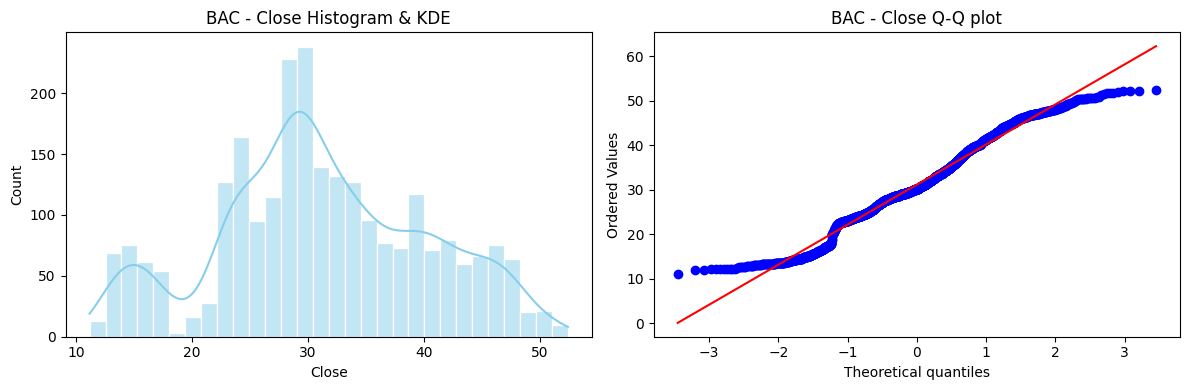

--- Phân phối cho C (Close) ---


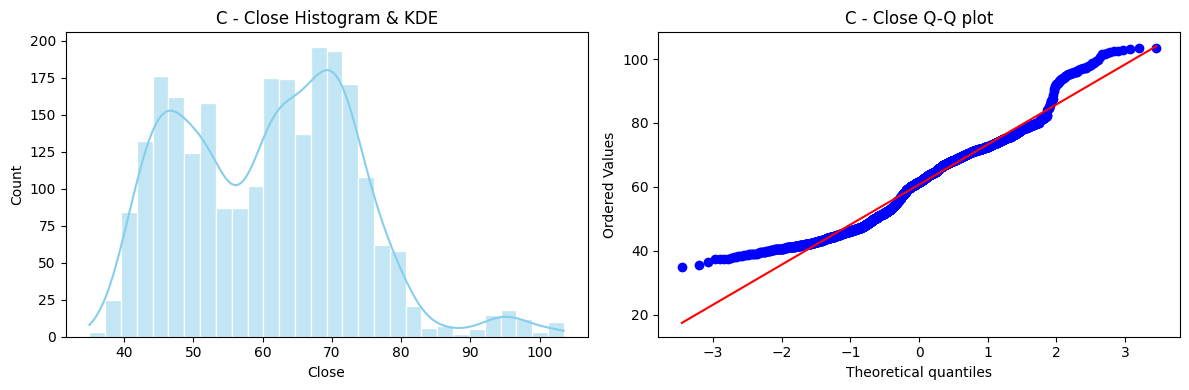

--- Phân phối cho COF (Close) ---


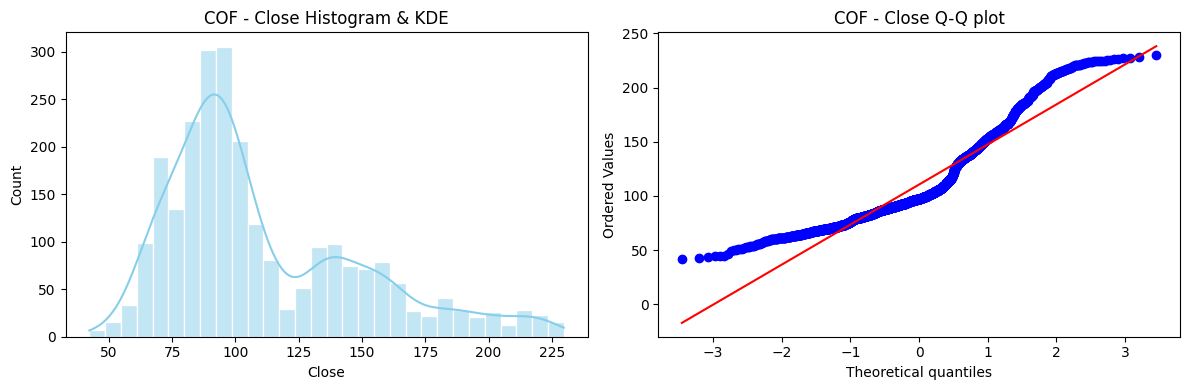

--- Phân phối cho GS (Close) ---


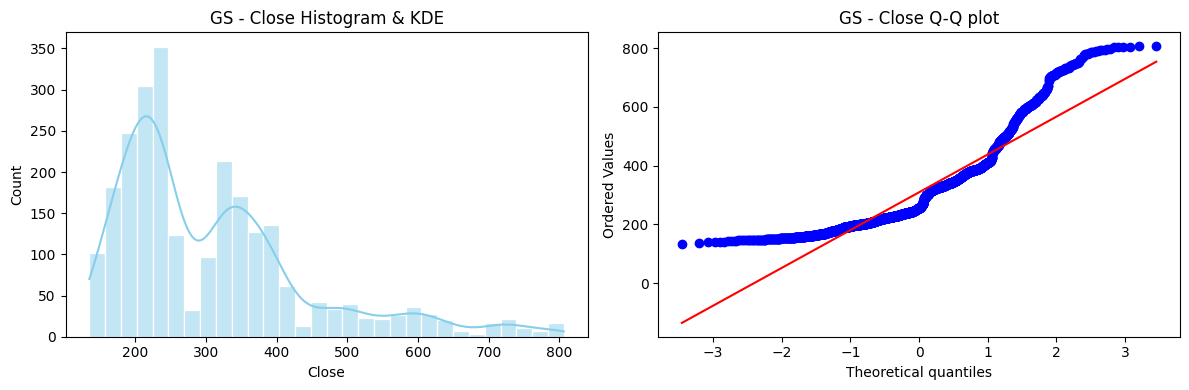

--- Phân phối cho JPM (Close) ---


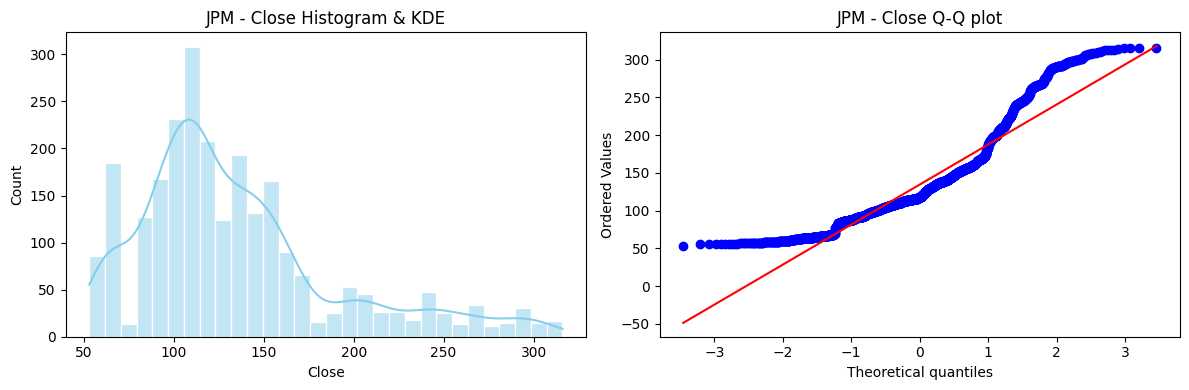

--- Phân phối cho MS (Close) ---


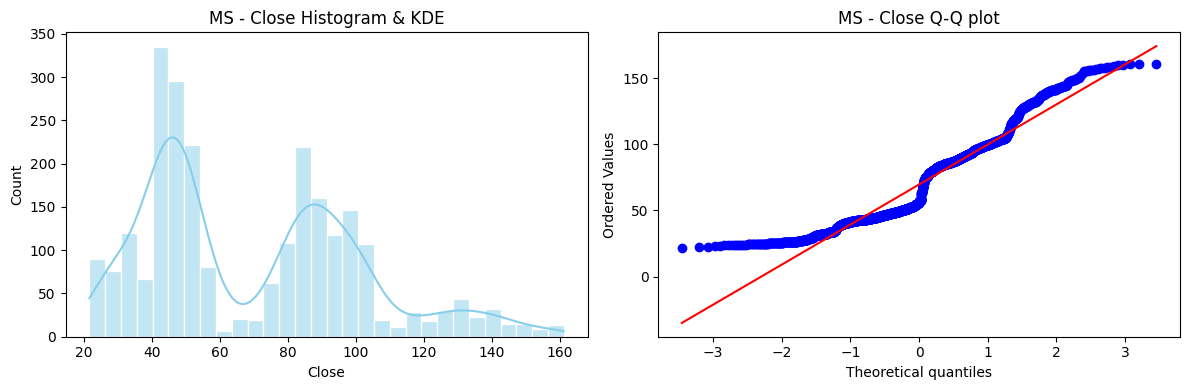

--- Phân phối cho PNC (Close) ---


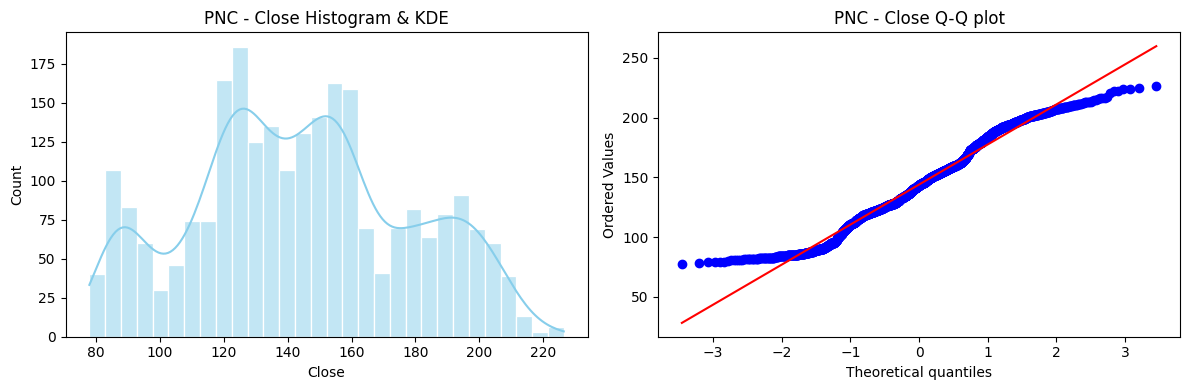

--- Phân phối cho TFC (Close) ---


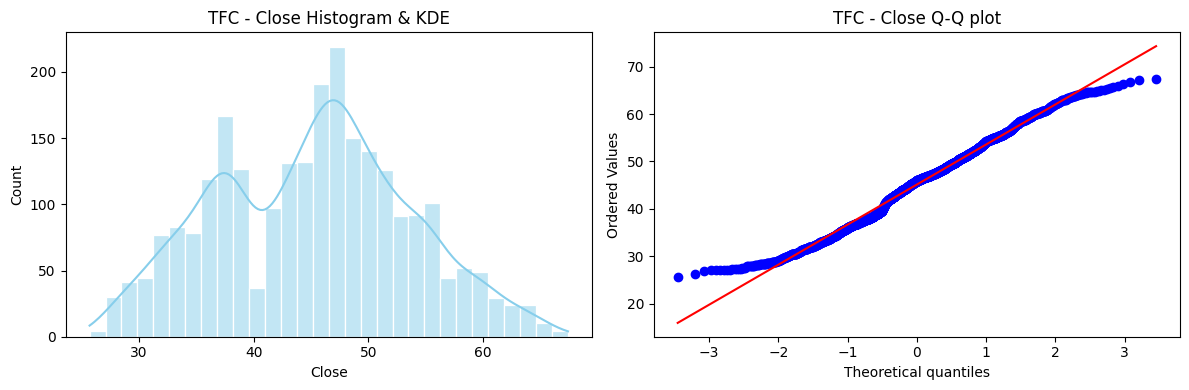

--- Phân phối cho USB (Close) ---


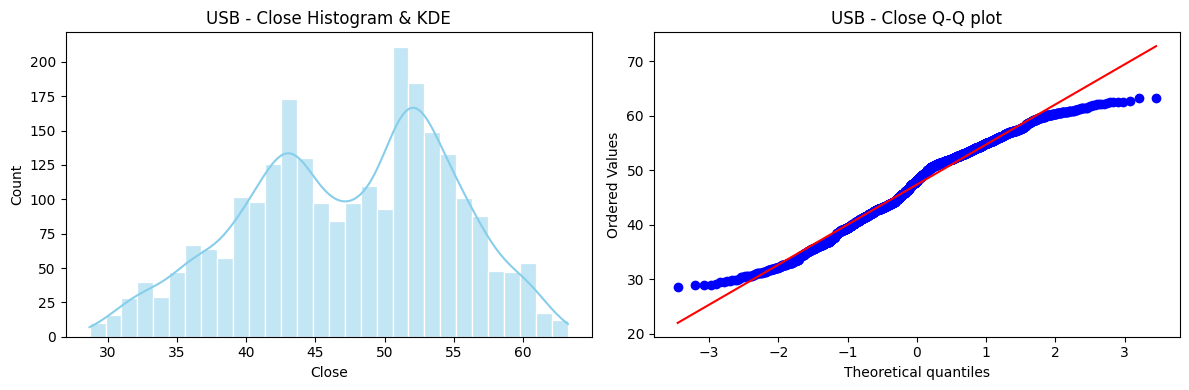

--- Phân phối cho WFC (Close) ---


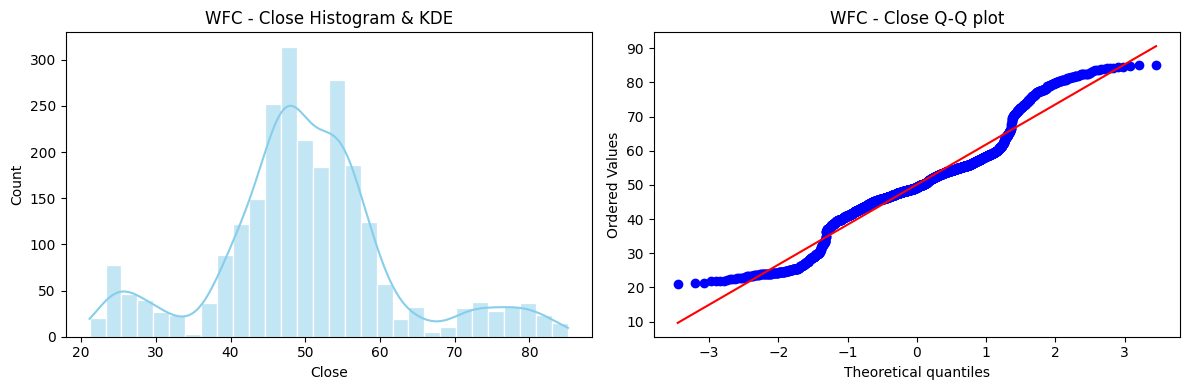

In [46]:
import scipy.stats as stats
tickers = data_final['US_Bank'].unique()

for ticker in tickers:
    df_t = data_final[data_final['US_Bank'] == ticker]
    print(f"--- Phân phối cho {ticker} (Close) ---")

    plt.figure(figsize=(12,4))

    # Histogram + KDE
    #Phân bố tần số của một biến liên tục, giúp thấy hình dạng phân phối lệch trái/phải, nheieuf đỉnh, đồng đều, chia data thành các bins, chiều cao=tần số/tỉ lệ
    #KDE phiên bản mượt của Histogram
    plt.subplot(1,2,1)
    sns.histplot(df_t['Close'].dropna(), kde=True, bins=30, color='skyblue', edgecolor='white')
    plt.title(f'{ticker} - Close Histogram & KDE')

    # Q-Q plot
    #Kiểm tra phân phối lý thuyết (chuẩn) hay không nếu chuẩn thì data nằm gần đường chéo
    plt.subplot(1,2,2)
    stats.probplot(df_t['Close'].dropna(), dist="norm", plot=plt)
    plt.title(f'{ticker} - Close Q-Q plot')

    plt.tight_layout()
    plt.show()

##Xử lý missing value

In [48]:
print("\n Số lượng giá trị thiếu trước khi xử lý:\n")
print(data_final.isna().sum())

numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adjusted Close', 'Volume']
existing_numeric = [col for col in numeric_cols if col in data_final.columns]
# Dùng forward fill (ffill): điền giá trị bị thiếu bằng giá trị gần nhất phía trước
# Dùng backward fill (bfill): điền giá trị bị thiếu còn lại (đầu chuỗi) bằng giá trị phía sau
# Dùng transform để giữ nguyên index khi groupby
data_final[existing_numeric] = (
    data_final
    .groupby('US_Bank')[existing_numeric]
    .transform(lambda g: g.ffill().bfill())
)

print("\n Đã xử lý missing value (ffill + bfill)\n")



 Số lượng giá trị thiếu trước khi xử lý:

Date              0
US_Bank           0
Open              0
High              0
Low               0
Close             0
Adjusted Close    0
Volume            0
dtype: int64

 Đã xử lý missing value (ffill + bfill)



In [62]:
data_final.to_csv("finance_data.csv")

# Download fundamental data

In [49]:
results = []


#  Vòng lặp qua từng mã cổ phiếu

for ticker_symbol in us_bank_tickers:
    try:
        ticker = yf.Ticker(ticker_symbol)
        info = ticker.info  #  Thông tin cơ bản tổng hợp (fundamentals summary)

        # ----- Lấy Total Assets (Tổng tài sản) từ balance_sheet -----
        total_assets = None
        try:
            balance = ticker.balance_sheet
            if "Total Assets" in balance.index:
                total_assets = balance.loc["Total Assets"].iloc[0]
        except Exception:
            pass

        # ----- Lấy Free Cash Flow (Dòng tiền tự do) từ cashflow -----
        free_cashflow = None
        try:
            cf = ticker.cashflow
            if (
                "Total Cash From Operating Activities" in cf.index
                and "Capital Expenditures" in cf.index
            ):
                free_cashflow = (
                    cf.loc["Total Cash From Operating Activities"].iloc[0]
                    - cf.loc["Capital Expenditures"].iloc[0]
                )
        except Exception:
            pass

        # ----- Gom tất cả dữ liệu lại -----
        results.append({
            "Ticker": ticker_symbol,
            "Tên công ty": info.get("longName", "N/A"),              # Tên đầy đủ của doanh nghiệp
            "Ngành": info.get("industry", "N/A"),                    # Lĩnh vực hoạt động
            "Vốn hóa thị trường": info.get("marketCap", None),       # Market Cap = Giá × Số cổ phiếu
            "Chỉ số P/E": info.get("trailingPE", None),              # Price/Earnings Ratio
            "Chỉ số P/B": info.get("priceToBook", None),             # Price/Book Ratio
            "Tỷ suất cổ tức (%)": (info.get("dividendYield", 0) or 0) * 100,  # Dividend Yield (%)
            "Lợi nhuận ròng": info.get("netIncomeToCommon", None),   # Net Income to common shareholders
            "Dòng tiền tự do": free_cashflow,                        # Free Cash Flow (Operating - CapEx)
            "Tổng tài sản": total_assets,                            # Total Assets (từ balance sheet)
            "Tổng thu nhập": info.get("totalRevenue", None),         # Total Revenue
            "Nợ phải trả": info.get("totalDebt", None)               # Total Debt
        })

    except Exception as e:
        print(f"Không lấy được dữ liệu cho {ticker_symbol}: {e}")


#  Đưa vào DataFrame và định dạng lại

df = pd.DataFrame(results)

# Làm đẹp số liệu lớn: hiển thị có dấu phẩy ngăn cách hàng nghìn
numeric_cols = [
    "Vốn hóa thị trường", "Lợi nhuận ròng", "Dòng tiền tự do",
    "Tổng tài sản", "Tổng thu nhập", "Nợ phải trả"
]
for col in numeric_cols:
    df[col] = df[col].apply(lambda x: f"{x:,}" if isinstance(x, (int, float)) else x)

# In toàn bộ kết quả
print(df.to_string(index=False))


#  Giải thích cơ bản từng chỉ số

explanation = {
    "Ticker": "Mã cổ phiếu của ngân hàng trên sàn giao dịch.",
    "Tên công ty": "Tên đầy đủ của tổ chức tài chính phát hành cổ phiếu.",
    "Ngành": "Lĩnh vực hoạt động chính (Banks - Diversified, Banks - Regional, ...).",
    "Vốn hóa thị trường": "Giá trị thị trường của toàn bộ cổ phiếu (đo quy mô công ty).",
    "Chỉ số P/E": "Giá / Lợi nhuận trên mỗi cổ phần — đo mức định giá theo lợi nhuận.",
    "Chỉ số P/B": "Giá / Giá trị sổ sách — đo định giá so với tài sản ròng.",
    "Tỷ suất cổ tức (%)": "Tỷ lệ cổ tức hàng năm so với giá cổ phiếu (%).",
    "Lợi nhuận ròng": "Lợi nhuận sau thuế thuộc về cổ đông thường.",
    "Dòng tiền tự do": "Tiền mặt còn lại sau khi chi đầu tư tài sản cố định (CapEx).",
    "Tổng tài sản": "Tổng giá trị tài sản của ngân hàng (tiền, khoản vay, đầu tư...).",
    "Tổng thu nhập": "Tổng doanh thu từ hoạt động kinh doanh (lãi, phí, v.v.).",
    "Nợ phải trả": "Tổng nợ ngắn hạn + dài hạn — thể hiện đòn bẩy tài chính."
}

print("\n Giải thích ý nghĩa các chỉ số:\n")
for k, v in explanation.items():
    print(f" - {k}: {v}")





Ticker                            Tên công ty               Ngành Vốn hóa thị trường  Chỉ số P/E  Chỉ số P/B  Tỷ suất cổ tức (%) Lợi nhuận ròng Dòng tiền tự do        Tổng tài sản   Tổng thu nhập       Nợ phải trả
   JPM                   JPMorgan Chase & Co. Banks - Diversified    860,892,889,088   15.506685    2.505502               192.0 56,660,000,768            None 4,002,814,000,000.0 167,228,997,632 1,148,076,032,000
   BAC            Bank of America Corporation Banks - Diversified    397,382,746,112   14.658470    1.413665               209.0 28,253,999,104            None 3,261,519,000,000.0 101,445,001,216   763,981,987,840
   WFC                  Wells Fargo & Company Banks - Diversified    275,015,434,240   14.143327    1.642936               210.0 19,971,999,744            None 1,929,845,000,000.0  79,072,002,048   424,136,998,912
     C                         Citigroup Inc. Banks - Diversified    190,717,018,112   14.550562    0.955640               232.0 13,436,999,680 

=>Dòng tiền tự do bị NaN vì ngân hàng hầu như không có chi tiêu vốn (CapEx), và báo cáo tài chính của họ không trình bày chỉ tiêu Free Cash Flow theo chuẩn doanh nghiệp thông thường

# Technical indicators


#SMA

## SMA – Simple Moving Average

**Khái niệm:**  
- SMA là **trung bình cộng** giá đóng cửa trong một khoảng thời gian xác định (gọi là “window”).  
- Giúp làm mượt dữ liệu giá, nhận biết **xu hướng tổng thể**: tăng, giảm hoặc đi ngang.

**Công thức:**

$$
SMA_n = \frac{P_1 + P_2 + \dots + P_n}{n}
$$


**Ví dụ:**  
Giả sử giá đóng cửa 5 ngày gần nhất là `[100, 102, 101, 105, 107]`.

$$
SMA(5) = \frac{100 + 102 + 101 + 105 + 107}{5} = 103
$$


**Cách hiểu:**  
- Nếu **giá hiện tại > SMA**, xu hướng tăng.  
- Nếu **giá hiện tại < SMA**, xu hướng giảm.  

**Tín hiệu giao dịch:**

| Tín hiệu | Điều kiện |
|----------|-----------|
| MUA      | Giá cắt lên SMA |
| BÁN      | Giá cắt xuống SMA |

**Position:**  
- Hold sau khi MUA, Cash sau khi BÁN.


#EMA

## EMA – Exponential Moving Average  

** Khái niệm:**  
- **EMA (Trung bình động lũy thừa)** là loại trung bình động **ưu tiên trọng số cao hơn cho các giá gần nhất**, giúp phản ứng nhanh hơn so với SMA.  
- Dùng để **phát hiện sớm xu hướng hoặc tín hiệu đảo chiều** của giá.


** Công thức:**  
$$
EMA_t = P_t \times k + EMA_{t-1} \times (1 - k)
$$

với  

$$
k = \frac{2}{n + 1}
$$


** Ví dụ minh họa:**  
Giả sử:  trung bình 5 phiên gần nhất
- EMA(5) hôm qua = 100  
- Giá hôm nay = 110  

Ta có:

$$
k = \frac{2}{5 + 1} = 0.333
$$

$$
EMA_{\text{hôm nay}} = 110 \times 0.333 + 100 \times (1 - 0.333) = 36.63 + 66.67 = 103.3
$$


** Cách hiểu:**  
- EMA **tăng nhanh** khi giá tăng mạnh, và **giảm nhanh** khi giá giảm mạnh.  
- Giúp **bắt nhịp xu hướng sớm hơn SMA**, nhưng cũng **dễ nhiễu** hơn khi thị trường đi ngang.


** Tín hiệu giao dịch:**

| Tín hiệu | Điều kiện |
|:----------|:-----------|
| **MUA (Buy)** | Giá **cắt lên trên EMA** |
| **BÁN (Sell)** | Giá **cắt xuống dưới EMA** |


**Position:**  
- **Hold:** Sau tín hiệu MUA → đang nắm giữ cổ phiếu, kỳ vọng giá tiếp tục tăng.  
- **Cash:** Sau tín hiệu BÁN → đã bán ra, giữ tiền, chờ tín hiệu MUA mới.




#MACD

## MACD – Moving Average Convergence Divergence

**Khái niệm:**  
- Đo **khoảng cách giữa hai EMA** để xác định sức mạnh và hướng xu hướng.  
- Gồm ba thành phần:  
  - **MACD line** = EMA(12) – EMA(26)  
  - **Signal line** = EMA(9) của MACD  
  - **Histogram** = MACD – Signal  

**Ví dụ:**  
Giả sử:  
- EMA(12) = 105  
- EMA(26) = 100  

$$
MACD = 105 - 100 = 5
$$

Giả sử Signal line = 4  

$$
Histogram = 5 - 4 = 1
$$

→ Histogram dương (1) → xu hướng tăng nhẹ.

**Cách hiểu:**  
- MACD > 0 → xu hướng **tăng**.  
- MACD < 0 → xu hướng **giảm**.  
- Histogram càng lớn → **động lượng tăng/giảm càng mạnh**.

**Tín hiệu giao dịch:**

| Tín hiệu | Điều kiện |
|----------|-----------|
| **MUA**  | MACD cắt **lên** đường Signal |
| **BÁN**  | MACD cắt **xuống** đường Signal |

**Position:**  
- **Hold** khi MACD **trên** Signal → tiếp tục giữ cổ phiếu.  
- **Cash** khi MACD **dưới** Signal → đã bán, giữ tiền, chờ cơ hội mới.



#RSI

## RSI – Relative Strength Index

**Khái niệm:**  
- RSI đo **tốc độ và mức thay đổi của giá** để xác định cổ phiếu đang “**quá mua**” (overbought) hay “**quá bán**” (oversold).  
- Dao động trong **khoảng 0–100**.

**Công thức:**  

$$
RSI = 100 - \frac{100}{1 + RS}
$$

với  

$$
RS = \frac{\text{Average Gain}}{\text{Average Loss}}
$$

**Ví dụ:**  
Trong 14 ngày:  
- Average Gain = 1.5  
- Average Loss = 0.5  

$$
RS = \frac{1.5}{0.5} = 3
$$

$$
RSI = 100 - \frac{100}{1 + 3} = 75
$$

→ RSI = 75 → vùng **quá mua** (có thể điều chỉnh giảm).

**Cách hiểu:**  
- **RSI > 70** → Quá mua → giá có thể điều chỉnh giảm.  
- **RSI < 30** → Quá bán → giá có thể hồi phục.  
- **RSI 30–70** → Vùng trung tính (sideway).

**Tín hiệu giao dịch:**

| Tín hiệu | Điều kiện |
|----------|-----------|
| **MUA**  | RSI cắt **lên** mức 30 |
| **BÁN**  | RSI cắt **xuống** mức 70 |

**Position:**  
- **Hold** khi RSI nằm **trong vùng trung tính (30–70)** → tiếp tục giữ cổ phiếu.  
- **Cash** khi RSI **vào vùng quá mua hoặc quá bán** → nên chờ tín hiệu đảo chiều mới.



#Bollinger Bands

## Bollinger Bands (BB)

**Khái niệm:**  
- Bollinger Bands đo **mức biến động giá** quanh đường trung bình động đơn giản (SMA).  
- Gồm **3 đường chính**:  

$$
\text{Middle Band} = SMA(n)
$$

$$
\text{Upper Band} = SMA(n) + 2 \times \text{StdDev}
$$

$$
\text{Lower Band} = SMA(n) - 2 \times \text{StdDev}
$$

**Ví dụ:**  
Giả sử:  
- SMA(20) = 100  
- Độ lệch chuẩn (StdDev) = 5  

Khi đó:  
$$
\text{Upper Band} = 100 + 2 \times 5 = 110
$$
$$
\text{Lower Band} = 100 - 2 \times 5 = 90
$$

Nếu **giá hiện tại = 88** → chạm dải dưới → có thể **quá bán**, tín hiệu hồi phục.

**Cách hiểu:**  
- Giá chạm **dải trên** → có thể **quá mua**.  
- Giá chạm **dải dưới** → có thể **quá bán**.  
- Khoảng cách giữa hai dải **mở rộng** khi biến động giá tăng, **thu hẹp** khi thị trường bình lặng.

**Tín hiệu giao dịch:**

| Tín hiệu | Điều kiện |
|----------|-----------|
| **MUA**  | Giá chạm hoặc xuyên **dải dưới** rồi bật tăng trở lại |
| **BÁN**  | Giá chạm hoặc xuyên **dải trên** rồi quay đầu giảm |

**Position:**  
- **Hold** khi giá dao động **trong vùng giữa hai dải** → xu hướng ổn định.  
- **Cash** khi giá **phá vỡ dải trên hoặc dải dưới** → rủi ro tăng, nên chờ xác nhận lại xu hướng.



#Stochastic Oscillator

## Stochastic Oscillator (Chỉ báo Dao động Ngẫu nhiên)

**Khái niệm:**  
- So sánh **giá đóng cửa hiện tại** với **biên độ giá cao–thấp** trong một giai đoạn (thường là 14 ngày).  
- Gồm hai đường:  
  - **%K:** đo vị trí hiện tại của giá.  
  - **%D:** EMA(3) của %K (đường tín hiệu).

**Công thức:**  

$$
\%K = \frac{C - L_n}{H_n - L_n} \times 100
$$

Trong đó:  
- \( C \): Giá đóng cửa hiện tại  
- \( H_n \): Giá cao nhất trong n phiên gần nhất  
- \( L_n \): Giá thấp nhất trong n phiên gần nhất  
- Thường \( n = 14 \)

**Ví dụ:**  
Trong 14 ngày gần nhất:  
- \( H_{14} = 110 \)  
- \( L_{14} = 90 \)  
- \( C = 100 \)

$$
\%K = \frac{100 - 90}{110 - 90} \times 100 = 50
$$

→ %K = 50 → trung tính.  
Nếu %K tăng lên 80 → vùng **quá mua**, có thể sắp đảo chiều.

**Tín hiệu giao dịch:**

| Tín hiệu | Điều kiện |
|----------|-----------|
| **MUA**  | %K cắt lên %D tại vùng < 20 |
| **BÁN**  | %K cắt xuống %D tại vùng > 80 |

**Position:**  
- **Hold** khi %K và %D hướng lên (tăng ổn định).  
- **Cash** khi %K và %D hướng xuống (giảm ổn định).



#P/E

## P/E – Price-to-Earnings Ratio (Chỉ số Giá trên Lợi nhuận)

**Khái niệm:**  
- Đo **mức giá mà nhà đầu tư sẵn sàng trả** cho **mỗi 1 đồng lợi nhuận** của doanh nghiệp.  
- Giúp đánh giá **mức độ đắt/rẻ** của cổ phiếu so với lợi nhuận hiện tại.

**Công thức:**  

$$
P/E = \frac{\text{Giá cổ phiếu}}{\text{EPS}}
$$

Trong đó:  
- \( \text{Giá cổ phiếu} \): giá hiện tại trên thị trường  
- \( \text{EPS} \): lợi nhuận trên mỗi cổ phần (Earnings Per Share)

**Ví dụ:**  
Giả sử:  
- Giá cổ phiếu = 50,000 VND  
- EPS = 5,000 VND  

$$
P/E = \frac{50,000}{5,000} = 10
$$

**Cách hiểu:**  
- \( P/E = 10 \) → Nhà đầu tư trả **10 đồng** để có **1 đồng lợi nhuận**.  
- P/E **thấp** → cổ phiếu có thể **rẻ**, hoặc công ty **ít tăng trưởng**.  
- P/E **cao** → thể hiện **kỳ vọng tăng trưởng cao**, nhưng **rủi ro định giá**.

**Ứng dụng:**  
- So sánh với **P/E trung bình ngành** để xác định cổ phiếu đang **định giá cao hay thấp**.  
- Kết hợp với các chỉ số khác (P/B, PEG, ROE…) để có đánh giá toàn diện hơn.



#P/B

## P/B – Price-to-Book Ratio (Chỉ số Giá trên Giá trị sổ sách)

**Khái niệm:**  
- Đo **mức giá thị trường** so với **giá trị sổ sách** (book value) của một cổ phiếu.  
- Giúp đánh giá mức độ **định giá cao hay thấp** của doanh nghiệp so với tài sản thực.

**Công thức:**  

$$
P/B = \frac{\text{Giá cổ phiếu}}{\text{Giá trị sổ sách trên mỗi cổ phiếu}}
$$

Trong đó:  
- \( \text{Giá cổ phiếu} \): giá hiện tại của cổ phiếu trên thị trường.  
- \( \text{Giá trị sổ sách trên mỗi cổ phiếu} = \frac{\text{Tổng tài sản} - \text{Nợ phải trả}}{\text{Số lượng cổ phiếu đang lưu hành}} \)

**Ví dụ:**  
Giả sử:  
- Giá cổ phiếu = 30,000 VND  
- Giá trị sổ sách = 20,000 VND  

$$
P/B = \frac{30,000}{20,000} = 1.5
$$

**Cách hiểu:**  
- \( P/B < 1 \) → cổ phiếu có thể **bị định giá thấp** (thị trường đánh giá thấp hơn giá trị sổ sách).  
- \( P/B > 1 \) → thị trường **định giá cao hơn giá trị thực**, thường do kỳ vọng tăng trưởng.

**Ứng dụng:**  
- Thường dùng cho **doanh nghiệp có tài sản hữu hình lớn** như ngân hàng, bảo hiểm, bất động sản.  
- Kết hợp với **ROE (Return on Equity)** để đánh giá hiệu quả sử dụng vốn.



#Divided Yield

## Tỷ suất Cổ tức – Dividend Yield

**Khái niệm:**  
- Đo **mức lợi nhuận từ cổ tức hàng năm** so với **giá cổ phiếu hiện tại**.  
- Phản ánh **tỷ lệ sinh lời bằng tiền mặt** mà nhà đầu tư nhận được hàng năm từ việc nắm giữ cổ phiếu.

**Công thức:**  

$$
Dividend\ Yield = \frac{\text{Cổ tức trên mỗi cổ phiếu}}{\text{Giá cổ phiếu}} \times 100\%
$$

Trong đó:  
- \( \text{Cổ tức trên mỗi cổ phiếu} \): số tiền công ty chi trả cho mỗi cổ phiếu thường.  
- \( \text{Giá cổ phiếu} \): giá hiện tại của cổ phiếu trên thị trường.

**Ví dụ:**  
Giả sử:  
- Cổ tức = 2,000 VND/cp  
- Giá cổ phiếu = 40,000 VND  

$$
Dividend\ Yield = \frac{2,000}{40,000} \times 100\% = 5\%
$$

**Cách hiểu:**  
- **Dividend Yield cao** → cổ phiếu mang lại thu nhập ổn định, phù hợp với nhà đầu tư **dài hạn** hoặc **thu nhập thụ động**.  
- **Dividend Yield thấp** → công ty giữ lại lợi nhuận để **tái đầu tư**, phù hợp với nhà đầu tư tìm kiếm **tăng trưởng vốn**.

**Ứng dụng:**  
- Thường được sử dụng trong chiến lược **Value Investing** cùng với các chỉ số như **P/E** và **P/B**.  
- Giúp so sánh giữa các cổ phiếu hoặc với **lãi suất ngân hàng** để đánh giá hiệu quả đầu tư.



# Trading strategies

##1 indicator

BAC DataFrame:
           Date Global_Bank       Open       High        Low      Close  \
5022 2015-10-14         BAC  15.770000  15.920000  15.550000  15.640000   
5023 2015-10-15         BAC  15.810000  16.280001  15.720000  16.190001   
5024 2015-10-16         BAC  16.290001  16.290001  16.030001  16.120001   
5025 2015-10-19         BAC  16.000000  16.209999  15.980000  16.139999   
5026 2015-10-20         BAC  16.160000  16.290001  16.100000  16.200001   

      Adjusted Close      Volume  
5022       12.591783  32043325.0  
5023       13.034585  32043325.0  
5024       12.978231  32043325.0  
5025       12.994328  32043325.0  
5026       13.042636  32043325.0  


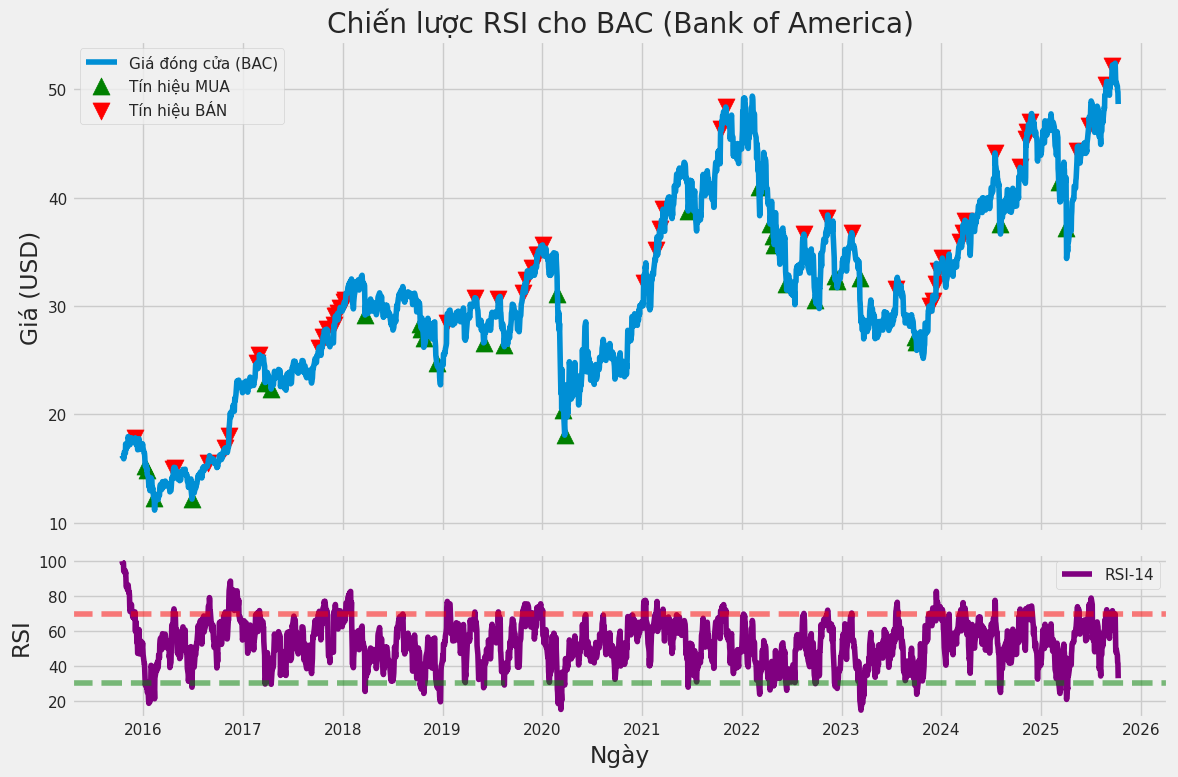

In [ ]:
import pandas_ta as ta
import matplotlib.pyplot as plt

# --- LỌC DỮ LIỆU CHO BAC ---
bac_data = data_final[data_final['Global_Bank'] == 'BAC'].copy()

# Kiểm tra dữ liệu
print("BAC DataFrame:")
print(bac_data.head())

# ---  TÍNH TOÁN RSI (14 ngày) ---
bac_data.ta.rsi(length=14, append=True)
bac_data.dropna(inplace=True)

# ---  TẠO TÍN HIỆU GIAO DỊCH ---
rsi_oversold = 30
rsi_overbought = 70

bac_data['Signal'] = 0
buy_condition = (bac_data['RSI_14'].shift(1) > rsi_oversold) & (bac_data['RSI_14'] <= rsi_oversold)
sell_condition = (bac_data['RSI_14'].shift(1) < rsi_overbought) & (bac_data['RSI_14'] >= rsi_overbought)

bac_data.loc[buy_condition, 'Signal'] = 1
bac_data.loc[sell_condition, 'Signal'] = -1

# ---  TRỰC QUAN HÓA ---
plt.style.use('fivethirtyeight')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Biểu đồ giá & tín hiệu
ax1.plot(bac_data['Date'], bac_data['Close'], label='Giá đóng cửa (BAC)')
ax1.scatter(bac_data.loc[bac_data['Signal'] == 1, 'Date'],
            bac_data.loc[bac_data['Signal'] == 1, 'Close'],
            label='Tín hiệu MUA', marker='^', color='green', s=150)
ax1.scatter(bac_data.loc[bac_data['Signal'] == -1, 'Date'],
            bac_data.loc[bac_data['Signal'] == -1, 'Close'],
            label='Tín hiệu BÁN', marker='v', color='red', s=150)

ax1.set_title('Chiến lược RSI cho BAC (Bank of America)')
ax1.set_ylabel('Giá (USD)')
ax1.legend()

# Biểu đồ RSI
ax2.plot(bac_data['Date'], bac_data['RSI_14'], label='RSI-14', color='purple')
ax2.axhline(rsi_overbought, linestyle='--', color='red', alpha=0.5)
ax2.axhline(rsi_oversold, linestyle='--', color='green', alpha=0.5)
ax2.set_ylabel('RSI')
ax2.set_xlabel('Ngày')
ax2.legend()

plt.tight_layout()
plt.show()



# Test using historical data

##1 indicator

/tmp/ipython-input-393812118.py:8: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  bac_data['Position'] = bac_data['Signal'].replace(to_replace=0, method='ffill')  # giữ trạng thái mua/bán trước đó



===== Hiệu suất Backtest RSI Strategy trên BAC =====
Tổng lợi nhuận thị trường (Buy & Hold): 180.57%
Tổng lợi nhuận chiến lược RSI:         0.00%


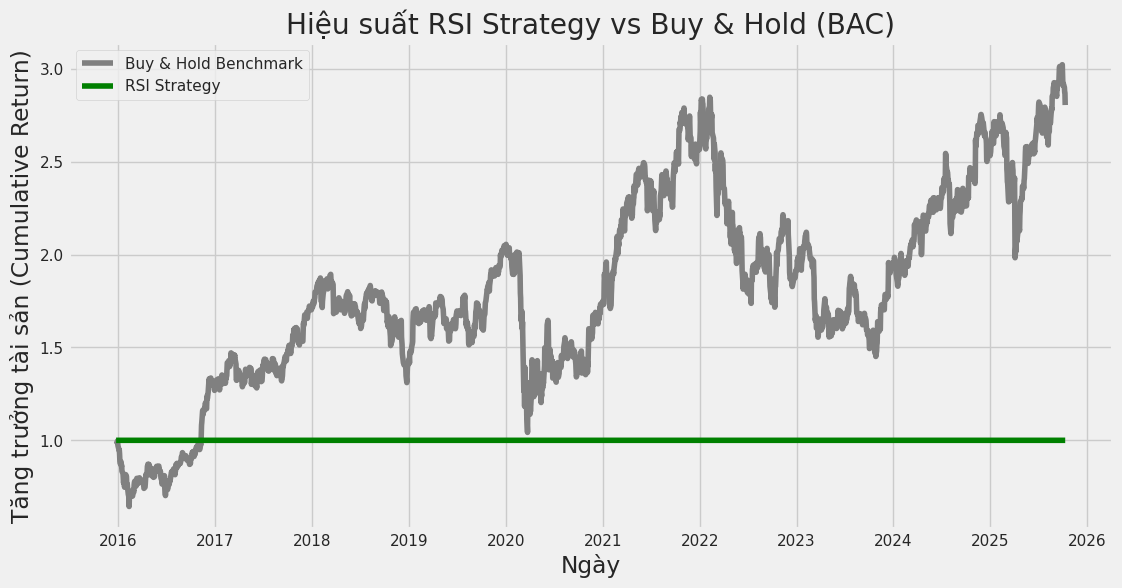

In [ ]:
# --- BACKTEST CHIẾN LƯỢC RSI DỰA TRÊN DỮ LIỆU LỊCH SỬ --- #

#  Tính tỷ suất lợi nhuận hằng ngày
bac_data['Return'] = bac_data['Close'].pct_change()

#  Xây dựng tín hiệu vị thế (giữ cổ phiếu khi Signal=1, không giữ khi Signal=0)
# Sử dụng tín hiệu RSI để quyết định giữ lệnh
bac_data['Position'] = bac_data['Signal'].replace(to_replace=0, method='ffill')  # giữ trạng thái mua/bán trước đó
bac_data['Position'] = bac_data['Position'].shift(1).fillna(0)  # tránh look-ahead bias

#  Tính lợi nhuận chiến lược
bac_data['Strategy_Return'] = bac_data['Position'] * bac_data['Return']

#  Tính lợi nhuận tích lũy
bac_data['Cumulative_Market'] = (1 + bac_data['Return']).cumprod()
bac_data['Cumulative_Strategy'] = (1 + bac_data['Strategy_Return']).cumprod()

#  Hiển thị kết quả cuối cùng
print("\n===== Hiệu suất Backtest RSI Strategy trên BAC =====")
print(f"Tổng lợi nhuận thị trường (Buy & Hold): {bac_data['Cumulative_Market'].iloc[-1] - 1:.2%}")
print(f"Tổng lợi nhuận chiến lược RSI:         {bac_data['Cumulative_Strategy'].iloc[-1] - 1:.2%}")

# Vẽ biểu đồ so sánh hiệu suất
plt.figure(figsize=(12, 6))
plt.plot(bac_data['Date'], bac_data['Cumulative_Market'], label='Buy & Hold Benchmark', color='gray')
plt.plot(bac_data['Date'], bac_data['Cumulative_Strategy'], label='RSI Strategy', color='green')
plt.title('Hiệu suất RSI Strategy vs Buy & Hold (BAC)')
plt.xlabel('Ngày')
plt.ylabel('Tăng trưởng tài sản (Cumulative Return)')
plt.legend()
plt.grid(True)
plt.show()


# Trading strategies using fundamental data

## Value Stocks

- Đây là cổ phiếu của những công ty tốt, ổn định nhưng đang được thị trường định giá thấp hơn giá trị thực của chúng.
- **Đặc điểm**: Công ty đã trưởng thành, có lịch sử kinh doanh lâu dài. Thường xuyên trả cổ tức đều đặn. Chỉ số P/E (Giá/Lợi nhuận) và P/B (Giá/Giá trị sổ sách) thấp hơn so với trung bình ngành. Hoạt động trong các ngành truyền thống như ngân hàng, hàng tiêu dùng, năng lượng.

## Growth Stocks


- Đây là cổ phiếu của những công ty được kỳ vọng sẽ tăng trưởng nhanh hơn nhiều so với phần còn lại của thị trường.
- **Đặc điểm**: Tăng trưởng doanh thu và lợi nhuận vượt trội. Thường không trả cổ tức (hoặc rất ít) vì họ tái đầu tư toàn bộ lợi nhuận để phát triển. Chỉ số P/E thường rất cao, vì nhà đầu tư sẵn sàng trả giá cao cho tiềm năng tương lai. Hoạt động trong các ngành đổi mới như công nghệ, phần mềm, y tế, thương mại điện tử.

## Implement Code

## Dùng P/E,P/B,Dividend Yield

In [50]:
import yfinance as yf
import pandas as pd


# --- Ngưỡng xác định cổ phiếu giá trị ---
PE_THRESHOLD = 12.0 #Price/Earnings<12 rẻ so với lợi nhuận
PB_THRESHOLD = 1.2 #Price/Book<1.2 rẻ so với giá trị sổ sách
DIVIDEND_YIELD_THRESHOLD = 0.025  # Dividend Yield>2.5% trả cổ tức tốt

value_banks = []

print("---  BẮT ĐẦU SÀNG LỌC CÁC NGÂN HÀNG GIÁ TRỊ TOÀN CẦU ---\n")

for ticker_str in us_bank_tickers:
    try:
        info = yf.Ticker(ticker_str).info
        name = info.get("shortName", ticker_str)
        pe = info.get("trailingPE", float("inf"))
        pb = info.get("priceToBook", float("inf"))
        dy = info.get("dividendYield", 0.0)

        print(f" {ticker_str} ({name}): P/E={pe:.2f}, P/B={pb:.2f}, Cổ tức={dy:.2%}")

        # Đếm số tiêu chí đạt chuẩn
        conditions_met = sum([
            pe < PE_THRESHOLD,
            pb < PB_THRESHOLD,
            dy > DIVIDEND_YIELD_THRESHOLD
        ])

        # Nếu đạt ít nhất 2 tiêu chí → cổ phiếu giá trị
        if conditions_met >= 2:
            value_banks.append({
                "Mã CK": ticker_str,
                "Tên": name,
                "P/E": round(pe, 2),
                "P/B": round(pb, 2),
                "Cổ tức (%)": round(dy * 100, 2),
                "Số tiêu chí đạt": conditions_met
            })

    except Exception as e:
        print(f" Lỗi khi xử lý {ticker_str}: {e}")

# --- Xuất kết quả ---
print("\n---  KẾT QUẢ: NGÂN HÀNG GIÁ TRỊ TIỀM NĂNG ---")
if value_banks:
    df_value = pd.DataFrame(value_banks)
    print(df_value.to_string(index=False))
else:
    print("Không có ngân hàng nào thỏa mãn tiêu chí định giá thấp.")


---  BẮT ĐẦU SÀNG LỌC CÁC NGÂN HÀNG GIÁ TRỊ TOÀN CẦU ---

 JPM (JP Morgan Chase & Co.): P/E=15.51, P/B=2.51, Cổ tức=192.00%
 BAC (Bank of America Corporation): P/E=14.66, P/B=1.41, Cổ tức=209.00%
 WFC (Wells Fargo & Company): P/E=14.14, P/B=1.64, Cổ tức=210.00%
 C (Citigroup, Inc.): P/E=14.55, P/B=0.96, Cổ tức=232.00%
 GS (Goldman Sachs Group, Inc. (The)): P/E=16.78, P/B=2.37, Cổ tức=194.00%
 MS (Morgan Stanley): P/E=17.38, P/B=2.69, Cổ tức=236.00%
 USB (U.S. Bancorp): P/E=11.22, P/B=1.35, Cổ tức=424.00%
 PNC (PNC Financial Services Group, I): P/E=12.31, P/B=1.41, Cổ tức=357.00%
 TFC (Truist Financial Corporation): P/E=12.47, P/B=1.00, Cổ tức=447.00%
 COF (Capital One Financial Corporati): P/E=75.28, P/B=1.28, Cổ tức=146.00%

---  KẾT QUẢ: NGÂN HÀNG GIÁ TRỊ TIỀM NĂNG ---
Mã CK                          Tên   P/E  P/B  Cổ tức (%)  Số tiêu chí đạt
    C              Citigroup, Inc. 14.55 0.96       232.0                2
  USB                 U.S. Bancorp 11.22 1.35       424.0           

##Dùng Revenue Growth,Earnings Growth

In [51]:
import yfinance as yf
import pandas as pd

# Danh sách các mã cổ phiếu ngân hàng toàn cầu

tickers = us_bank_tickers
growth_stocks = []

# --- Ngưỡng sàng lọc cổ phiếu tăng trưởng ---
REVENUE_GROWTH_THRESHOLD = 0.01    # Revenue Growth (tăng trưởng doanh thu) > 1%
EARNINGS_GROWTH_THRESHOLD = 0.015  # Earnings Growth (tăng trưởng lợi nhuận) > 1.5%

print("\n--- BẮT ĐẦU SÀNG LỌC CỔ PHIẾU TĂNG TRƯỞNG ---")
for ticker_str in tickers:
    try:
        info = yf.Ticker(ticker_str).info
        name = info.get('shortName', ticker_str)
        revenue_growth = info.get('revenueGrowth', 0.0)
        earnings_growth = info.get('earningsGrowth', 0.0)
        pe_ratio = info.get('trailingPE', None)

        print(f"Đang xử lý {name}: Tăng trưởng DT={revenue_growth:.2%}, Tăng trưởng LN={earnings_growth:.2%}")

        if revenue_growth > REVENUE_GROWTH_THRESHOLD and earnings_growth > EARNINGS_GROWTH_THRESHOLD:
            growth_stocks.append({
                "Mã CK": ticker_str,
                "Tên": name,
                "Tăng trưởng DT (%)": revenue_growth * 100,
                "Tăng trưởng LN (%)": earnings_growth * 100,
                "P/E": pe_ratio
            })
    except Exception as e:
        print(f"Lỗi khi xử lý {ticker_str}: {e}")

print("\n--- KẾT QUẢ: CÁC CỔ PHIẾU TĂNG TRƯỞNG TIỀM NĂNG ---")
if growth_stocks:
    df_growth = pd.DataFrame(growth_stocks)
    print(df_growth.to_string(index=False))
else:
    print("Không tìm thấy cổ phiếu nào thỏa mãn các tiêu chí.")



--- BẮT ĐẦU SÀNG LỌC CỔ PHIẾU TĂNG TRƯỞNG ---
Đang xử lý JP Morgan Chase & Co.: Tăng trưởng DT=8.80%, Tăng trưởng LN=16.00%
Đang xử lý Bank of America Corporation: Tăng trưởng DT=12.60%, Tăng trưởng LN=31.50%
Đang xử lý Wells Fargo & Company: Tăng trưởng DT=7.50%, Tăng trưởng LN=16.90%
Đang xử lý Citigroup, Inc.: Tăng trưởng DT=11.60%, Tăng trưởng LN=23.20%
Đang xử lý Goldman Sachs Group, Inc. (The): Tăng trưởng DT=20.70%, Tăng trưởng LN=45.80%
Đang xử lý Morgan Stanley: Tăng trưởng DT=19.10%, Tăng trưởng LN=48.90%
Đang xử lý U.S. Bancorp: Tăng trưởng DT=7.20%, Tăng trưởng LN=18.50%
Đang xử lý PNC Financial Services Group, I: Tăng trưởng DT=10.80%, Tăng trưởng LN=24.60%
Đang xử lý Truist Financial Corporation: Tăng trưởng DT=2.50%, Tăng trưởng LN=4.80%
Đang xử lý Capital One Financial Corporati: Tăng trưởng DT=67.90%, Tăng trưởng LN=9.50%

--- KẾT QUẢ: CÁC CỔ PHIẾU TĂNG TRƯỞNG TIỀM NĂNG ---
Mã CK                             Tên  Tăng trưởng DT (%)  Tăng trưởng LN (%)       P/E
  JPM  

# Momentum strategies using price-volume data

## Khái niệm

- Chiến lược momentum (hay chiến lược theo đà) là một phương pháp đầu tư dựa trên nguyên tắc đơn giản: những tài sản đã tăng giá mạnh trong quá khứ gần đây có khả năng sẽ tiếp tục tăng, và ngược lại.
- Triết lý cốt lõi đằng sau nó là "xu hướng là bạn" (the trend is your friend). Thay vì cố gắng "mua đáy bán đỉnh", nhà đầu tư theo chiến lược momentum sẽ đi theo xu hướng đã được hình thành.

## Chiến lược hoạt động

- Xác định Chu kỳ Nhìn lại: Chọn một khoảng thời gian trong quá khứ để đo lường hiệu suất, thường là 3 tháng, 6 tháng, hoặc 12 tháng.
- Xếp hạng Tài sản: Xếp hạng các cổ phiếu (hoặc tài sản khác) dựa trên tổng lợi nhuận của chúng trong chu kỳ nhìn lại đó.
- Mua "Kẻ Thắng" và Bán "Kẻ Thua":
- Mua: Bạn mua những cổ phiếu nằm trong top đầu của bảng xếp hạng (ví dụ: top 10% hoặc 20%).
- Bán: Bạn bán những cổ phiếu nằm ở cuối bảng xếp hạng.
- Lặp lại Định kỳ: Lặp lại quy trình này sau một khoảng thời gian nhất định (ví dụ: mỗi tháng hoặc mỗi quý) để cập nhật danh mục của mình.

## Ưu, nhược điểm

### Ưu điểm:
- Đã được chứng minh trong lịch sử: Nhiều nghiên cứu đã chỉ ra rằng chiến lược momentum đã mang lại lợi nhuận vượt trội trong nhiều giai đoạn lịch sử khác nhau.
- Logic đơn giản: Quy tắc mua/bán rất rõ ràng và có hệ thống.
- Có thể né được sụt giảm dài hạn: Vì chiến lược này bán đi các cổ phiếu đang hoạt động kém, nó có thể giúp bạn thoát khỏi những tài sản đang trong xu hướng giảm kéo dài.

### Nhược điểm:
- Rủi ro khi thị trường đảo chiều đột ngột: Đây là điểm yếu lớn nhất. Khi thị trường đang tăng mạnh và đột ngột sụp đổ, các cổ phiếu momentum sẽ bị thiệt hại nặng nề nhất.
- Chi phí giao dịch cao: Việc mua bán thường xuyên có thể tốn nhiều phí và thuế.
- Có thể bỏ lỡ giai đoạn phục hồi: Chiến lược này thường chỉ tham gia khi xu hướng tăng đã rõ ràng, do đó có thể bỏ lỡ những lợi nhuận lớn nhất khi thị trường vừa tạo đáy và bắt đầu đi lên.

## Implement Code

###Momentum Price

[*********************100%***********************]  1 of 1 completed


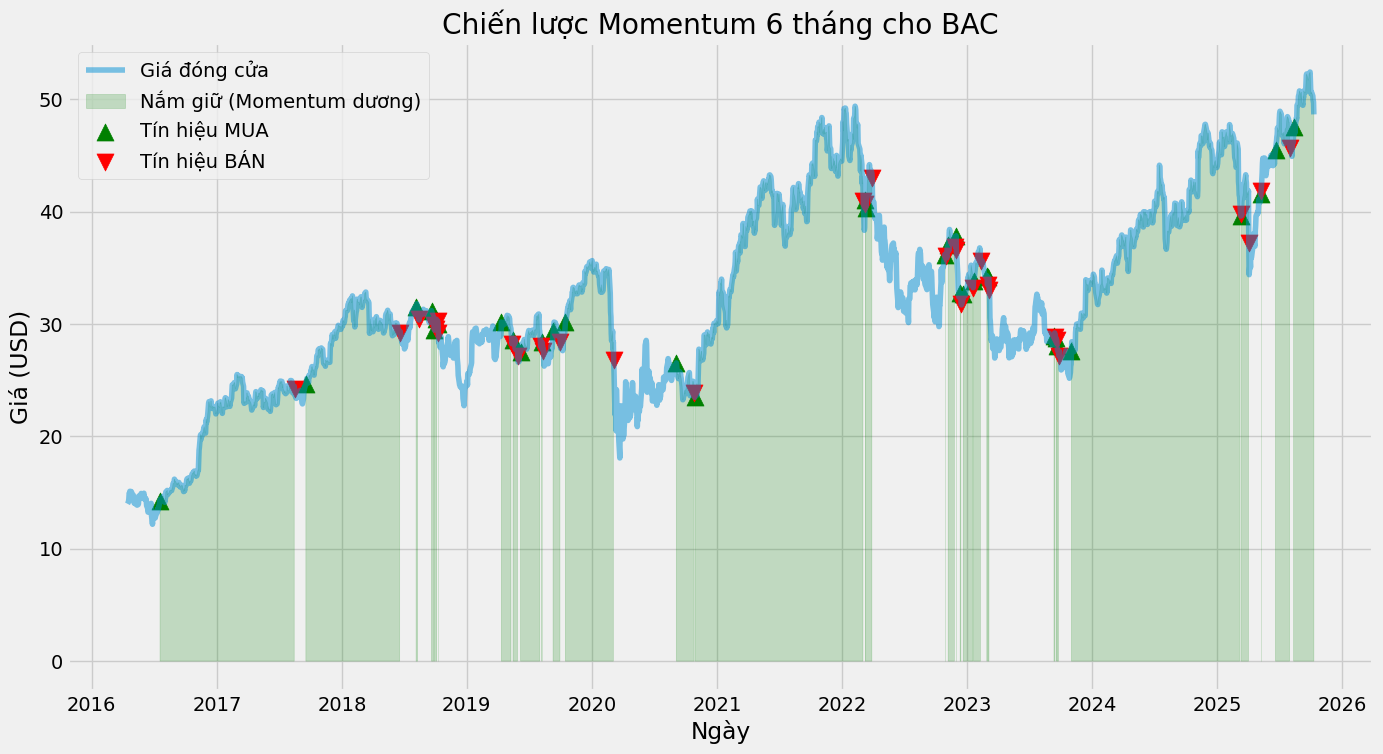

In [52]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Tải dữ liệu BAC ---
ticker = "BAC"
data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)

# --- 2. Tính Momentum 6 tháng ---
lookback_period = 126 #(số ngày giao dịch trong 6 tháng 21*6)
data['Momentum'] = data['Close'].pct_change(periods=lookback_period) #Tỉ lệ thay đổi giá so với 6 tháng trước Momemtum=Pt-Pt-126/Pt-126
data.dropna(inplace=True) #Loại bỏ các dòng đầu không đủ 126 ngày trước

# --- 3. Tín hiệu giao dịch ---
data['Signal'] = np.where(data['Momentum'] > 0, 1, 0) #Nếu momentum dương
data['Position'] = data['Signal'].diff()
#1: tín hiệu mua (bắt đầu momentum dương)
#-1: tín hiệu bán (kết thúc momentum dương)

# --- 4. Chuẩn bị dữ liệu 1D cho trực quan ---
close_price = data['Close'].squeeze()
signal = data['Signal'].squeeze()

# --- 5. Trực quan hóa ---
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 8))

plt.plot(close_price, label='Giá đóng cửa', alpha=0.5)
plt.fill_between(data.index, 0, close_price, where=signal==1,
                 color='green', alpha=0.2, label='Nắm giữ (Momentum dương)')

plt.scatter(data.index[data['Position']==1], close_price[data['Position']==1],
            label='Tín hiệu MUA', marker='^', color='green', s=150)
plt.scatter(data.index[data['Position']==-1], close_price[data['Position']==-1],
            label='Tín hiệu BÁN', marker='v', color='red', s=150)

plt.title(f'Chiến lược Momentum 6 tháng cho {ticker}')
plt.xlabel('Ngày')
plt.ylabel('Giá (USD)')
plt.legend()
plt.show()



--- KẾT QUẢ BACKTESTING BAC ---
Tổng lợi nhuận Chiến lược Momentum: 286.21%
Tổng lợi nhuận Mua và Giữ: 347.50%


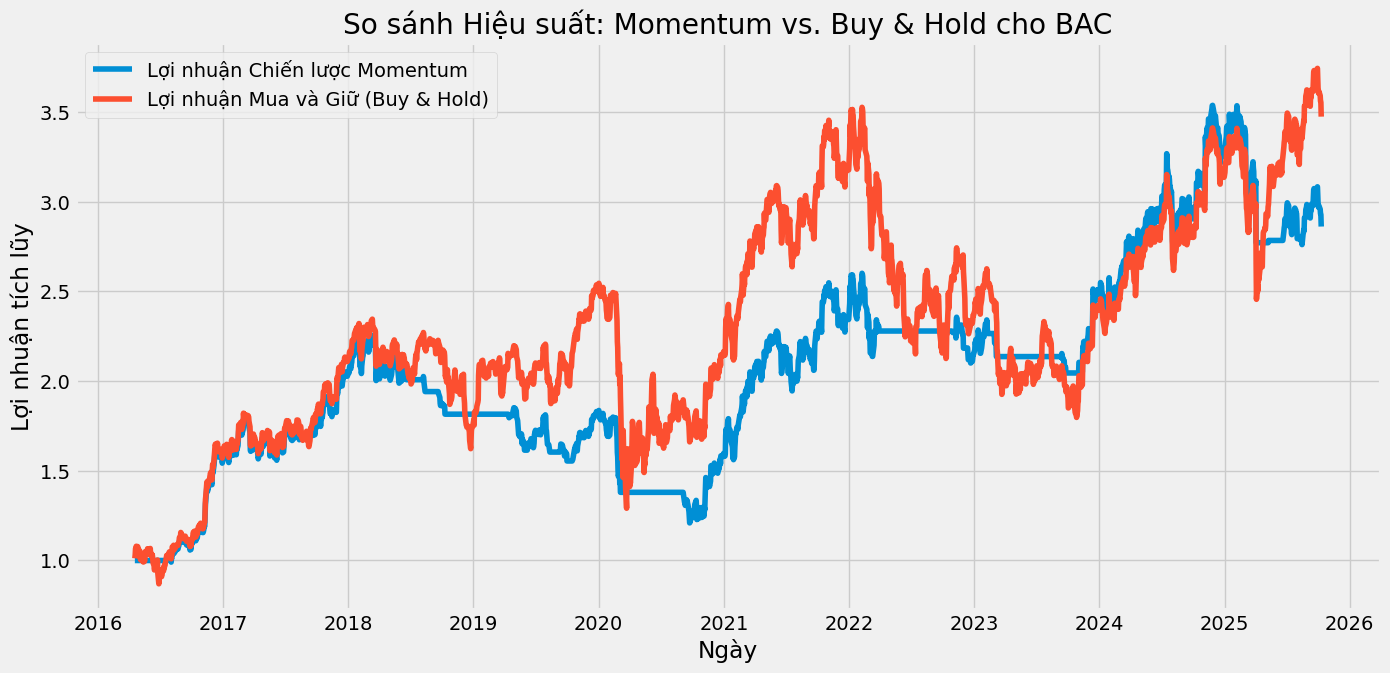

In [53]:
# --- 4. Backtest Chiến lược BAC ---

# Lợi nhuận hàng ngày của thị trường (Buy & Hold): tỷ suất thay đổi hàng ngày của giá đóng cửa
data['Market_Returns'] = data['Close'].pct_change()

# Lợi nhuận hàng ngày của chiến lược Momentum
# Chỉ tính khi đang nắm giữ cổ phiếu, tránh "look-ahead bias"
data['Strategy_Returns'] = data['Market_Returns'] * data['Signal'].shift(1) #Tránh look-ahead bias(không dùng tín hiệu cùng ngày để tính lợi nhuận)
#Nếu Signal =1 (nắm giữ)->Lợi nhuận =%thay đổi thực tế của giá
#Nếu Signal=0 (không nắm giữ)->Lợi nhuận=0
# Lợi nhuận tích lũy
data['Cumulative_Market_Returns'] = (1 + data['Market_Returns']).cumprod() #nếu mua và giữ
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod() #Lợi nhuận tích lũy theo momentum strategy

# --- In kết quả ---
print("--- KẾT QUẢ BACKTESTING BAC ---")
total_strategy_return = data['Cumulative_Strategy_Returns'].iloc[-1]
total_market_return = data['Cumulative_Market_Returns'].iloc[-1]
print(f"Tổng lợi nhuận Chiến lược Momentum: {total_strategy_return:.2%}")
print(f"Tổng lợi nhuận Mua và Giữ: {total_market_return:.2%}")

# --- Vẽ đường cong vốn ---
plt.figure(figsize=(15, 7))
plt.plot(data['Cumulative_Strategy_Returns'], label='Lợi nhuận Chiến lược Momentum')
plt.plot(data['Cumulative_Market_Returns'], label='Lợi nhuận Mua và Giữ (Buy & Hold)')
plt.title(f'So sánh Hiệu suất: Momentum vs. Buy & Hold cho {ticker}')
plt.xlabel('Ngày')
plt.ylabel('Lợi nhuận tích lũy')
plt.legend()
plt.show()


Momentum Strategy là chiến lược tăng trưởng theo xu hướng, tập trung vào việc nắm giữ khi thị trường tích cực.

Trong biểu đồ này:

Momentum giảm sự tiếp xúc với thị trường khi giá giảm, giúp giảm drawdown.

Tổng lợi nhuận dài hạn có thể thấp hơn Buy & Hold nếu cổ phiếu tăng ổn định mà không có nhiều nhịp giảm lớn.

Nhận xét: Momentum phù hợp khi thị trường biến động mạnh, có nhịp tăng-giảm liên tục.

Chiến lược này không tối ưu với cổ phiếu tăng đều trong dài hạn.

##Desing momentum strategies using price-volume data.

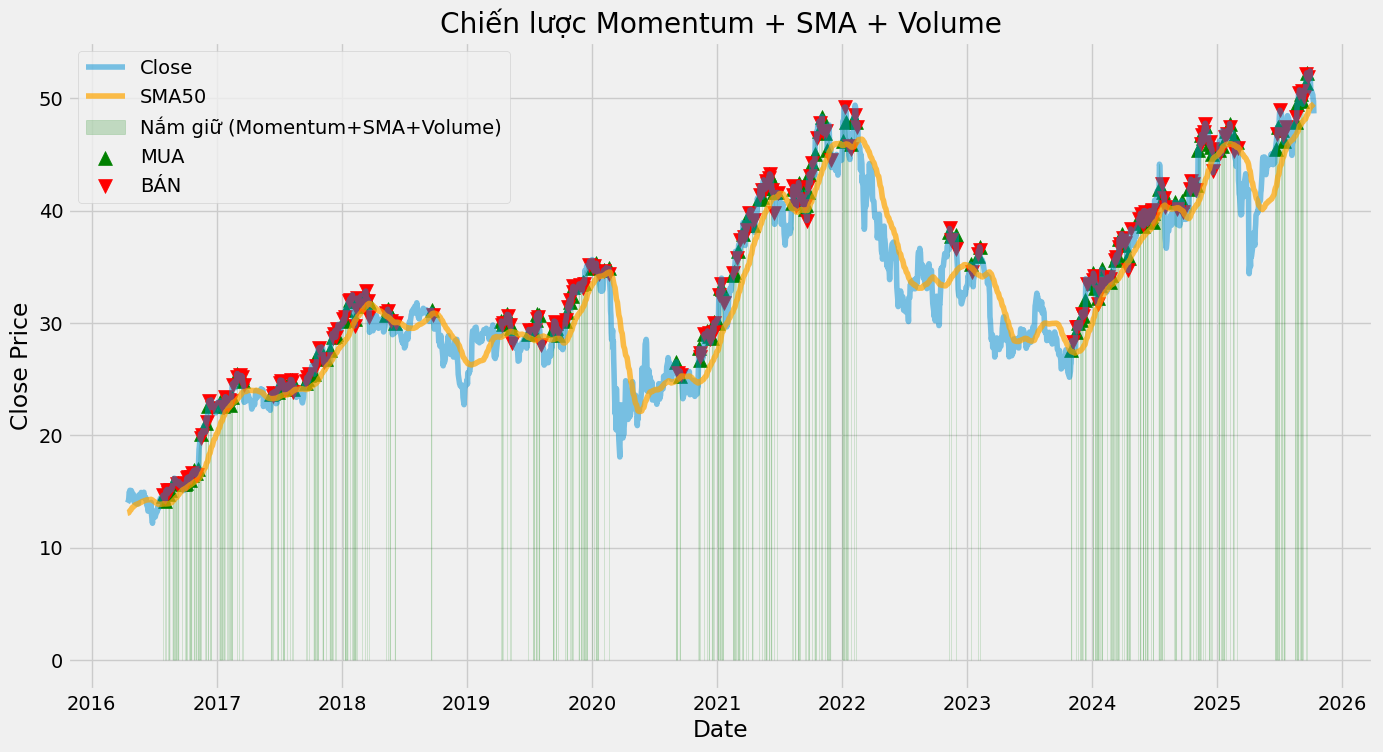

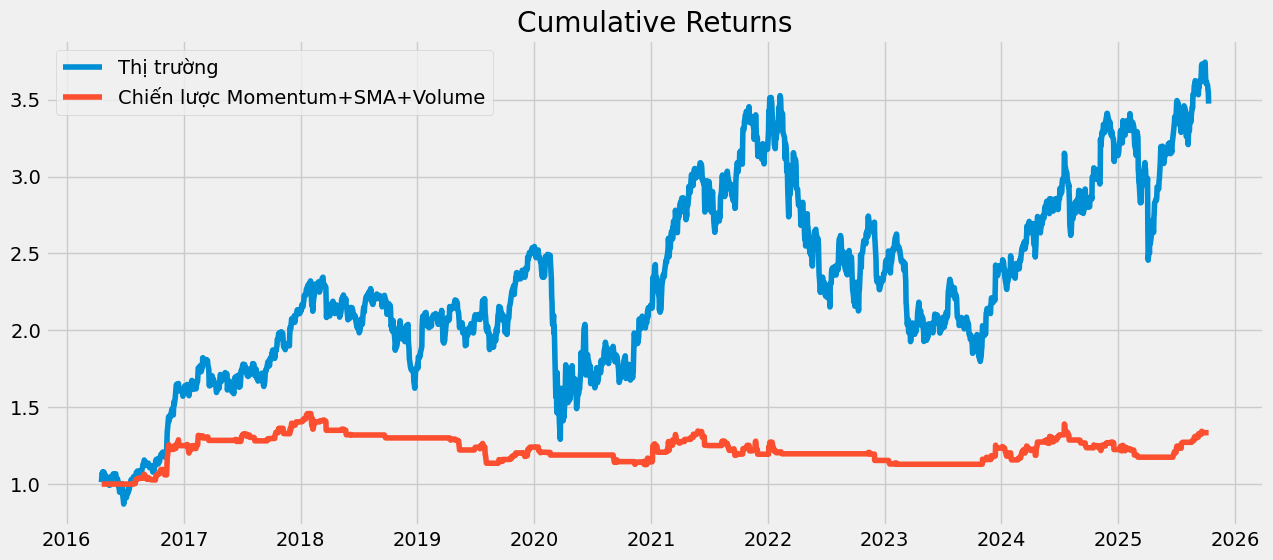

Total Strategy Return: 33.43%
Sharpe Ratio: 0.34


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = data_final[data_final['US_Bank'] == 'BAC'].copy() # DataFrame đã có cột 'Date', 'Close', 'Volume', v.v.
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# -------------------------
# 1. Tính Momentum 6 tháng (~126 phiên)
# -------------------------
lookback = 126
df['Momentum'] = df['Close'].pct_change(periods=lookback)

# -------------------------
# 2. Tính SMA50 và Volume MA20
# -------------------------
df['SMA50'] = df['Close'].rolling(50).mean()
df['Vol_MA20'] = df['Volume'].rolling(20).mean()

# Drop NaN tạo ra bởi pct_change và rolling
df.dropna(subset=['Momentum','SMA50','Vol_MA20'], inplace=True)

# -------------------------
# 3. Tạo tín hiệu Momentum + SMA + Volume
# -------------------------
df['Signal'] = 0
mask = (df['Momentum'] > 0) & (df['Close'] > df['SMA50']) & (df['Volume'] > df['Vol_MA20'])
df.loc[mask, 'Signal'] = 1

# Xác định điểm mua/bán
df['Position'] = df['Signal'].diff()  # 1=MUA, -1=BÁN

# -------------------------
# 4. Trực quan hóa
# -------------------------
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15,8))
plt.plot(df['Close'], label='Close', alpha=0.5)
plt.plot(df['SMA50'], label='SMA50', color='orange', alpha=0.7)
plt.fill_between(df.index, 0, df['Close'], where=df['Signal']==1,
                 color='green', alpha=0.2, label='Nắm giữ (Momentum+SMA+Volume)')
plt.scatter(df.index[df['Position']==1], df['Close'][df['Position']==1],
            marker='^', color='green', s=100, label='MUA')
plt.scatter(df.index[df['Position']==-1], df['Close'][df['Position']==-1],
            marker='v', color='red', s=100, label='BÁN')
plt.title('Chiến lược Momentum + SMA + Volume')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# -------------------------
# 5. Backtest
# -------------------------
df['Market_Returns'] = df['Close'].pct_change()
df.dropna(subset=['Market_Returns'], inplace=True)

# Shift Signal để tránh lookahead bias
signal, returns = df['Signal'].shift(1).align(df['Market_Returns'], join='inner')
df['Strategy_Returns'] = returns * signal

# Lợi nhuận tích lũy
df['Cumulative_Market'] = (1 + df['Market_Returns']).cumprod()
df['Cumulative_Strategy'] = (1 + df['Strategy_Returns']).cumprod()

# -------------------------
# 6. Vẽ cumulative returns
# -------------------------
plt.figure(figsize=(14,6))
plt.plot(df['Cumulative_Market'], label='Thị trường')
plt.plot(df['Cumulative_Strategy'], label='Chiến lược Momentum+SMA+Volume')
plt.legend()
plt.title('Cumulative Returns')
plt.show()

# -------------------------
# 7. Metrics cơ bản
# -------------------------
total_return = df['Cumulative_Strategy'].iloc[-1] - 1
sharpe_ratio = df['Strategy_Returns'].mean() / df['Strategy_Returns'].std() * np.sqrt(252)
print(f"Total Strategy Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


Lợi nhuận tích lũy của chiến lược Momentum + SMA + Volume trong khoảng thời gian backtest.

Total Strategy Return=33.43% là mức tăng đáng kể, nghĩa là nếu đầu tư 1 USD từ đầu, cuối kỳ bạn sẽ có khoảng 1.3343 USD.



Chỉ số này đo tỷ suất lợi nhuận trên rủi ro, nghĩa là lợi nhuận chiến lược trên mỗi đơn vị biến động (rủi ro).

Sharpe = 0.34 là rất thấp, có nghĩa là:

Chiến lược có lợi nhuận, nhưng biến động lợi nhuận cao.

Sharpe >1: chấp nhận được, >2: tốt, >3: xuất sắc.

Chiến lược này có tiềm năng tạo lợi nhuận, nhưng rủi ro tương đối cao.

Chiến lược này bảo toàn vốn tốt trong các cú sốc lớn, nhưng không tận dụng được các xu hướng mạnh của thị trường.

Nếu mục tiêu là bảo vệ vốn, chiến lược này có ích.

Nếu mục tiêu là tăng trưởng cao, cần tối ưu lại